## Import libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, pairwise_logrank_test

## Read simulation files

In [39]:
## Read random baseline simulation results
df_sim_random = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/withdrawn_user_random_baseline_simulation.csv')
df_sim_random.head()

,participant_id,actual_days,model_intrusive_pings,projected_days,v_model,reduction_rate
0,ambushdollhousegenerous@timestudy_com,100.0,767.04,124.895703,7.670400,0.2
1,anywaymustinesspushiness@timestudy_com,16.0,26.36,20.030349,1.647500,0.2
2,bottledeskworkrequire@timestudy_com,111.0,529.06,138.891619,4.766306,0.2
3,browsingfrisbeepersevere@timestudy_com,78.0,611.82,97.528685,7.843846,0.2
4,buckedstiflestagnant@timestudy_com,207.0,1315.36,258.561154,6.354396,0.2


In [40]:
## Read s1 threshold simulation results
df_sim1_thresholds = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/withdrawn_user_study_extension_setup1.csv')
df_sim1_thresholds.head()

,participant_id,threshold,f1,actual_days,projected_days,extension_days,v_lazy,v_model,saved_participant
0,ambushdollhousegenerous@timestudy_com,958,0.521739,100.0,365.00,265.00,9.5800,2.0200,1
1,anywaymustinesspushiness@timestudy_com,33,0.135922,16.0,27.79,11.79,2.0625,1.1875,0
2,bottledeskworkrequire@timestudy_com,662,0.383971,111.0,215.49,104.49,5.9640,3.0721,0
3,browsingfrisbeepersevere@timestudy_com,765,0.509105,78.0,365.00,287.00,9.8077,1.5641,1
4,buckedstiflestagnant@timestudy_com,1643,0.522926,207.0,365.00,158.00,7.9372,3.0338,1


In [41]:
## Read s2 threshold simulation results
df_sim2_thresholds = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/withdrawn_user_study_extension_setup2.csv')
df_sim2_thresholds.head()

,participant_id,threshold,actual_days,f1,projected_days,extension_days,v_lazy,v_model,saved_participant
0,ambushdollhousegenerous@timestudy_com,958,100.0,0.448617,365.0,265.0,9.5800,0.7400,1
1,anywaymustinesspushiness@timestudy_com,33,16.0,0.137313,52.8,36.8,2.0625,0.6250,0
2,bottledeskworkrequire@timestudy_com,662,111.0,0.366062,365.0,254.0,5.9640,1.5135,1
3,browsingfrisbeepersevere@timestudy_com,765,78.0,0.473062,365.0,287.0,9.8077,0.5769,1
4,buckedstiflestagnant@timestudy_com,1643,207.0,0.472386,365.0,158.0,7.9372,1.3671,1


## Survival analysis

In [42]:
def prepare_survival_dataframe(df_random, df_s1, df_s2):
    """
    Combines simulation results into a long-format DataFrame for statistical testing.
    The 'Actual (Lazy)' group is derived from the 'actual_days' column of the models.
    """
    data_list = []
    
    # 1. First, create the 'Actual (Lazy)' group using Ground Truth (actual_days)
    # We can pull this from any of the three dataframes as it is consistent across all.
    actual_df = pd.DataFrame({
        'duration': df_s1['actual_days'],
        'group': 'Actual (Lazy)',
        # For the withdrawn group, these are all observed events (they actually quit)
        'event': (df_s1['actual_days'] < 365.0).astype(int)
    })
    data_list.append(actual_df)

    # 2. Add the Simulated results (projected_days)
    mapping = {
        'Random (20% Block)': df_random,
        'Setup 1': df_s1,
        'Setup 2': df_s2
    }
    
    for label, df in mapping.items():
        temp_df = pd.DataFrame({
            'duration': df['projected_days'],
            'group': label,
            # Observed = 0 if they survive to 365 (Censored), else 1 (Event)
            'event': (df['projected_days'] < 365.0).astype(int)
        })
        data_list.append(temp_df)
    
    return pd.concat(data_list, ignore_index=True)

In [43]:
df_survival_master = prepare_survival_dataframe(df_sim_random, df_sim1_thresholds, df_sim2_thresholds)

In [44]:
def run_statistical_tests(df_long):
    """
    Performs Omnibus Log-Rank test followed by Pairwise Post-Hoc comparisons.
    """
    print("\n" + "="*60)
    print("      SURVIVAL STATISTICS: OMNIBUS & POST-HOC")
    print("="*60)

    # 1. Omnibus Test (Multivariate Log-Rank)
    results_omnibus = multivariate_logrank_test(
        df_long['duration'], 
        df_long['group'], 
        df_long['event']
    )
    
    print(f"OMNIBUS LOG-RANK TEST")
    print(f"p-value: {results_omnibus.p_value:.2e}")
    print(f"Test Statistic: {results_omnibus.test_statistic:.4f}")
    
    if results_omnibus.p_value < 0.05:
        print("\nRESULT: Significant difference detected between groups.")
        print("Proceeding to Pairwise Post-Hoc comparisons...")
        
        # 2. Pairwise Post-Hoc (Log-Rank)
        results_pairwise = pairwise_logrank_test(
            df_long['duration'], 
            df_long['group'], 
            df_long['event']
        )
        
        print("\nPAIRWISE LOG-RANK SUMMARY:")
        print(results_pairwise.summary[['test_statistic', 'p', '-log2(p)']])
    else:
        print("\nRESULT: No significant difference detected across groups.")

    print("="*60 + "\n")

In [49]:
run_statistical_tests(df_survival_master)


      SURVIVAL STATISTICS: OMNIBUS & POST-HOC
OMNIBUS LOG-RANK TEST
p-value: 1.31e-26
Test Statistic: 123.5734

RESULT: Significant difference detected between groups.
Proceeding to Pairwise Post-Hoc comparisons...

PAIRWISE LOG-RANK SUMMARY:
                                       test_statistic             p   -log2(p)
Actual (Lazy)      Random (20% Block)        3.940635  4.713299e-02   4.407119
                   Setup 1                  56.897803  4.590584e-14  44.308316
                   Setup 2                  81.296871  1.942339e-19  62.158839
Random (20% Block) Setup 1                  37.063377  1.143514e-09  29.703879
                   Setup 2                  61.222204  5.098330e-15  47.478897
Setup 1            Setup 2                   5.816453  1.587693e-02   5.976924



In [50]:
def plot_survival_curves(df_long):
    """
    Generates a high-quality Kaplan-Meier plot with all four conditions.
    """
    plt.figure(figsize=(12, 8))
    kmf = KaplanMeierFitter()
    
    # Define styling for visual clarity
    styles = {
        'Actual (Lazy)': {'color': 'black', 'ls': '--', 'alpha': 0.8},
        'Random (20% Block)': {'color': 'red', 'ls': ':', 'alpha': 0.7},
        'Setup 1': {'color': 'royalblue', 'ls': '-', 'alpha': 0.9},
        'Setup 2': {'color': 'forestgreen', 'ls': '-', 'alpha': 1.0}
    }

    # Iterate through unique groups to fit and plot
    for group_name in ['Actual (Lazy)', 'Random (20% Block)', 'Setup 1', 'Setup 2']:
        if group_name not in df_long['group'].unique():
            continue
            
        mask = df_long['group'] == group_name
        
        kmf.fit(
            durations=df_long.loc[mask, 'duration'],
            event_observed=df_long.loc[mask, 'event'],
            label=group_name
        )
        
        kmf.plot_survival_function(
            ci_show=True, 
            color=styles[group_name]['color'],
            linestyle=styles[group_name]['ls'],
            alpha=styles[group_name]['alpha'],
            lw=2.5 if 'Setup' in group_name else 1.5
        )

    # Chart Formatting
    plt.title("Counterfactual Survival Analysis: Impact of Intelligent Burden Reduction", fontsize=15, pad=20)
    plt.xlabel("Days in Study (Observation Period)", fontsize=13)
    plt.ylabel("Probability of Participant Retention", fontsize=13)
    plt.ylim(0, 1.05)
    plt.xlim(0, 370)
    plt.axvline(365, color='red', linestyle='--', alpha=0.3, label='Study End (Day 365)')
    
    plt.grid(True, which='major', linestyle='-', alpha=0.2)
    plt.legend(loc='lower left', fontsize=11, frameon=True)
    
    plt.tight_layout()
    plt.show()

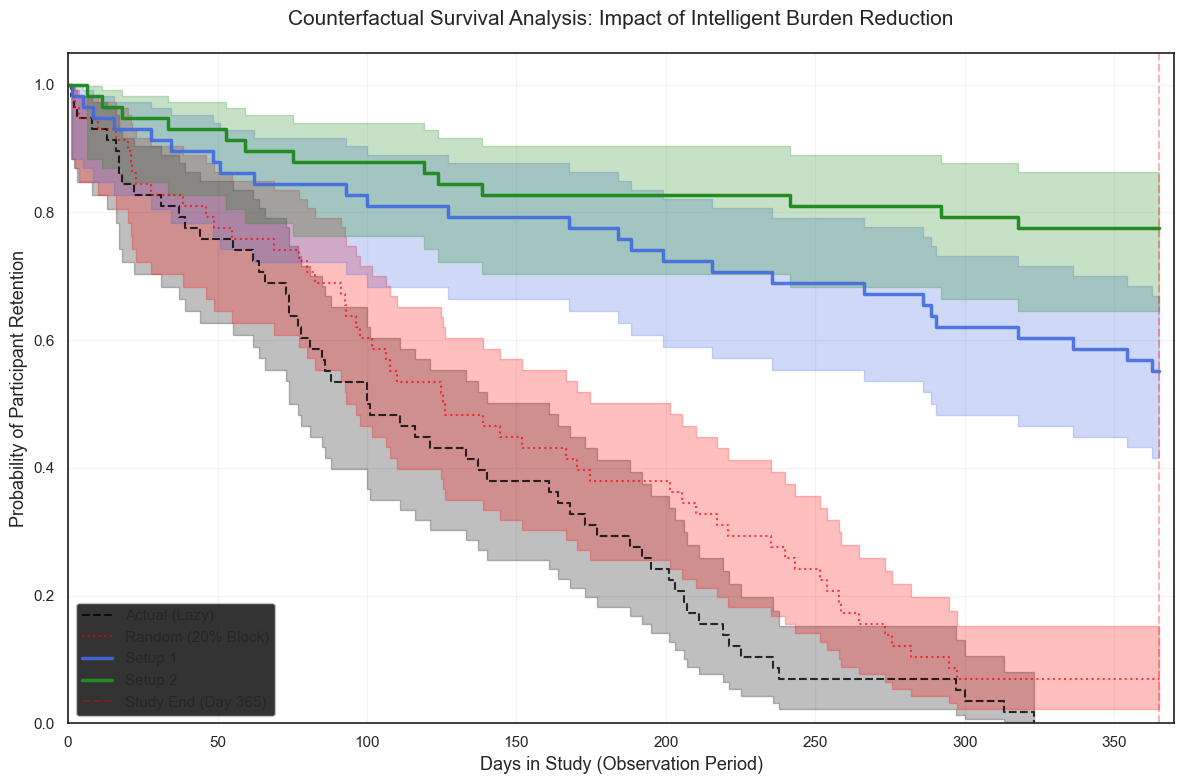

In [51]:
plot_survival_curves(df_survival_master)

In [52]:
def plot_retention_distributions(df_long):
    """
    Generates a 2x2 grid of density plots for each condition,
    highlighting the mean with a dashed line and text label on the line.
    All subplots share the same x and y axes for comparability.
    """
    # Define order and palette
    order = ['Actual (Lazy)', 'Random (20% Block)', 'Setup 1', 'Setup 2']
    palette = {
        'Actual (Lazy)': 'black',
        'Random (20% Block)': 'red',
        'Setup 1': 'royalblue',
        'Setup 2': 'forestgreen'
    }

    # Added sharey=True to ensure uniform y-axis scaling across the grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, group in enumerate(order):
        ax = axes[i]
        if group not in df_long['group'].unique():
            continue
            
        data = df_long[df_long['group'] == group]['duration']
        mean_val = data.mean()
        
        # Plot Density
        sns.kdeplot(
            data=data, 
            ax=ax,
            color=palette[group],
            fill=True,
            alpha=0.3,
            linewidth=2,
            bw_adjust=0.5
        )
        
        # Highlight mean with a dashed line
        ax.axvline(x=mean_val, color='black', linestyle='--', linewidth=1.5, alpha=0.8)
        
        # Write mean on the line
        # Use a relative position based on the current axis view
        y_limit = ax.get_ylim()[1]
        ax.text(
            mean_val + 2, 
            y_limit * 0.7, 
            f'Mean: {mean_val:.1f}d', 
            color='black', 
            fontweight='bold',
            rotation=0,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
        )

        # Study End Reference
        ax.axvline(365, color='red', linestyle='-', alpha=0.2)
        
        # Subplot Formatting
        ax.set_title(f"Condition: {group}", fontsize=13, fontweight='bold')
        ax.set_ylabel("Density" if i % 2 == 0 else "")
        ax.set_xlabel("Days in Study" if i >= 2 else "")
        ax.set_xlim(0, 400)
        ax.grid(True, linestyle=':', alpha=0.4)

    plt.suptitle("Retention Density Distribution Analysis", fontsize=17, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

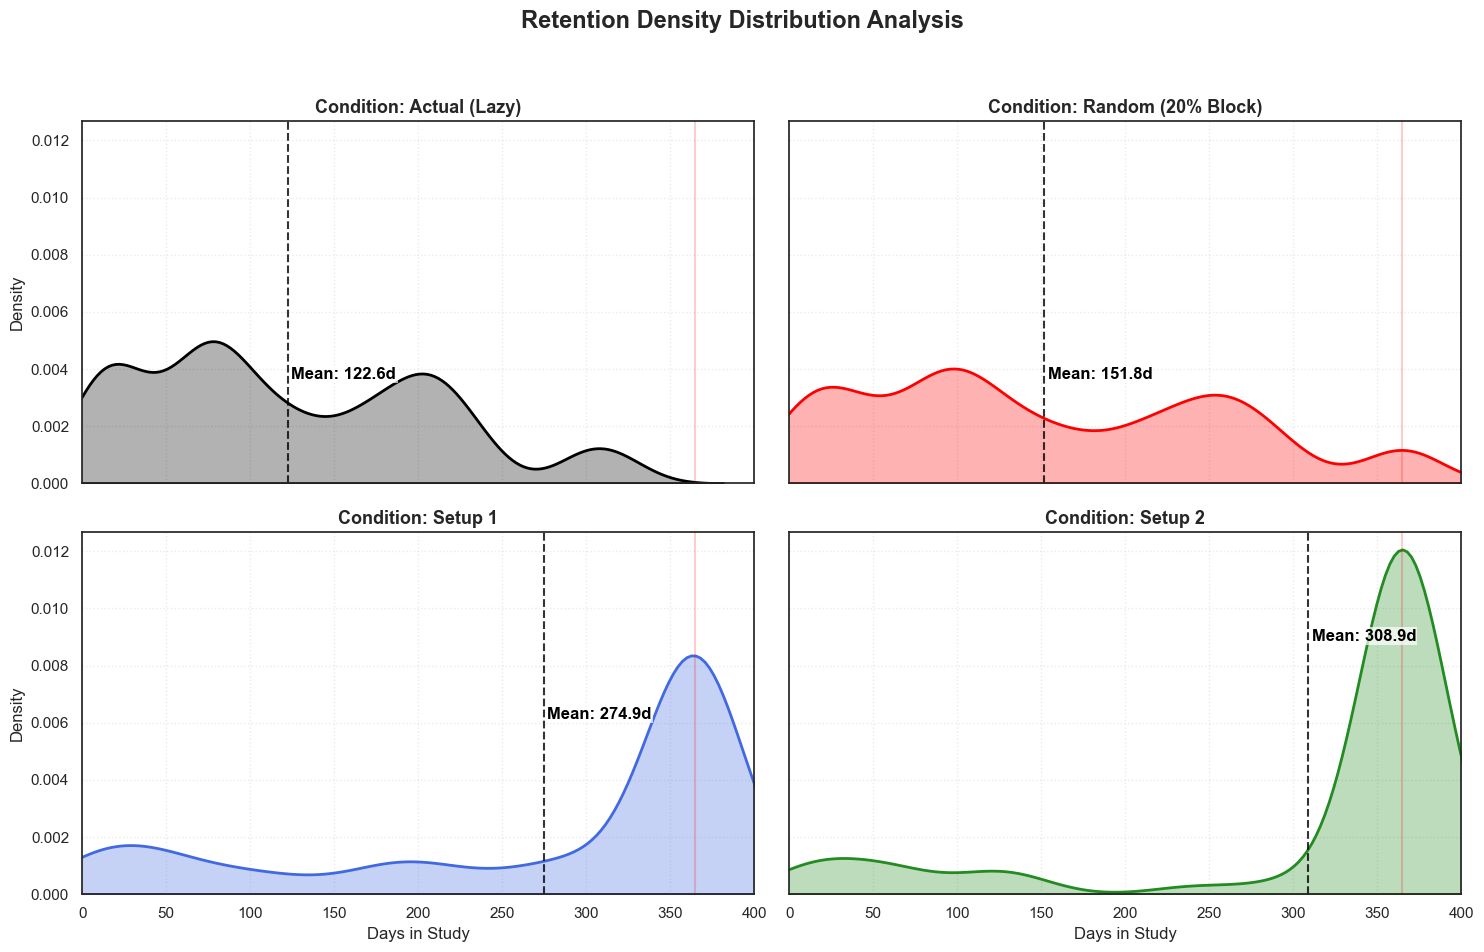

In [53]:
plot_retention_distributions(df_survival_master)

## Paired samples t-test for f1 scores

In [58]:
from scipy import stats

def compare_model_performance(df_s1, df_s2):
    """
    Performs a paired samples t-test and calculates Cohen's d for effect size.
    
    Args:
        df_s1: DataFrame for Setup 1 with columns ['participant_id', 'f1_score_c0']
        df_s2: DataFrame for Setup 2 with columns ['participant_id', 'f1_score_c0']
    """
    # 1. Merge the dataframes on participant_id to ensure paired alignment
    # We use inner join to ensure we only compare users present in both evaluations
    df_comp = pd.merge(
        df_s1[['participant_id', 'f1']], 
        df_s2[['participant_id', 'f1']], 
        on='participant_id', 
        suffixes=('_s1', '_s2')
    )

    if len(df_comp) < 2:
        print("Error: Not enough overlapping participants to perform a paired t-test.")
        return

    s1_scores = df_comp['f1_s1']
    s2_scores = df_comp['f1_s2']

    # 2. Perform Paired Samples T-Test
    # H0: There is no difference in mean F1 score between Setup 1 and Setup 2
    t_stat, p_val = stats.ttest_rel(s2_scores, s1_scores)

    # 3. Calculate Cohen's d for Paired Samples
    # Formula: Mean of differences / Standard Deviation of differences
    diffs = s2_scores - s1_scores
    cohen_d = np.mean(diffs) / np.std(diffs, ddof=1)

    # 4. Display Results
    print("\n" + "="*60)
    print("      STATISTICAL COMPARISON: SETUP 1 vs SETUP 2 (F1)")
    print("="*60)
    print(f"Number of Participants (N):  {len(df_comp)}")
    print(f"Setup 1 Mean F1 (Class 0):   {s1_scores.mean():.4f}")
    print(f"Setup 2 Mean F1 (Class 0):   {s2_scores.mean():.4f}")
    print(f"Mean Difference:             {np.mean(diffs):+.4f}")
    print("-" * 60)
    print(f"T-statistic:                 {t_stat:.4f}")
    print(f"P-value:                     {p_val:.2e}")
    print(f"Cohen's d (Effect Size):      {cohen_d:.4f}")
    print("-" * 60)

    # Interpretation
    if p_val < 0.05:
        verdict = "Statistically Significant"
        direction = "Setup 2 improved performance." if np.mean(diffs) > 0 else "Setup 1 performed better."
    else:
        verdict = "Not Statistically Significant"
        direction = "The performance difference is likely due to chance."

    print(f"VERDICT: {verdict}")
    print(f"INTERPRETATION: {direction}")
    
    # Cohen's d guidance
    if abs(cohen_d) < 0.2: effect = "Negligible"
    elif abs(cohen_d) < 0.5: effect = "Small"
    elif abs(cohen_d) < 0.8: effect = "Medium"
    else: effect = "Large"
    
    print(f"EFFECT MAGNITUDE: {effect}")
    print("="*60 + "\n")

    return df_comp

In [59]:
comparison_df = compare_model_performance(df_sim1_thresholds, df_sim2_thresholds)


      STATISTICAL COMPARISON: SETUP 1 vs SETUP 2 (F1)
Number of Participants (N):  58
Setup 1 Mean F1 (Class 0):   0.4258
Setup 2 Mean F1 (Class 0):   0.4078
Mean Difference:             -0.0179
------------------------------------------------------------
T-statistic:                 -3.4012
P-value:                     1.23e-03
Cohen's d (Effect Size):      -0.4466
------------------------------------------------------------
VERDICT: Statistically Significant
INTERPRETATION: Setup 1 performed better.
EFFECT MAGNITUDE: Small

